<a href="https://colab.research.google.com/github/fabrito2006/Laboratorio-16-MID/blob/main/Laboratorio_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 16 Calificado - Minería de Datos
#- Torres Alvarado, Fabricio Ismael

## 1. Tomando la información disponible en el repositorio UCI Machine Learning https://archive.ics.uci.edu/ml/datasets/Adult, uniendo los archivos ‘adult.data’ y ‘adult.test’, cuya variable de clasificación tiene las categorías ‘>50K’ y ‘<=50K’, haga lo siguiente:

### a. Realice el preprocesamiento de la información que incluya la corrección de errores, la imputación de datos faltantes, tratamiento de outliers a nivel univariado y multivariado, transformación de variables y análisis de correlación entras las variables predictoras.

In [50]:
!pip install ucimlrepo

In [51]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# Concat data
data = pd.concat([X, y], axis=1)

In [52]:
data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [53]:
# Visualizamos los valores nulos
columnas_nulas = data.columns[data.isnull().any()]
print(columnas_nulas)
data.isnull().sum()

Index(['workclass', 'occupation', 'native-country'], dtype='object')


,0
age,0
workclass,963
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,966
relationship,0
race,0
sex,0


In [54]:
# Identificar columnas categóricas con valores nulos
columnas_nulas_cat = [col for col in data.select_dtypes(include='object').columns if data[col].isnull().sum() > 0]
print("Columnas categóricas con nulos:", columnas_nulas_cat)

# Función para rellenar columnas categóricas con la moda
def rellenar_nulos_con_moda(data, columnas):
    for columna in columnas:
        if data[columna].isnull().sum() > 0:
            moda = data[columna].mode()[0]
            data[columna] = data[columna].fillna(moda)
            print(f"Se ha rellenado la columna '{columna}' con la moda: '{moda}'")
    return data

# Aplicar la función si hay columnas con nulos categóricos
if columnas_nulas_cat:
    data = rellenar_nulos_con_moda(data, columnas_nulas_cat)
else:
    print("No se encontraron columnas categóricas con nulos.")

Columnas categóricas con nulos: ['workclass', 'occupation', 'native-country']
Se ha rellenado la columna 'workclass' con la moda: 'Private'
Se ha rellenado la columna 'occupation' con la moda: 'Prof-specialty'
Se ha rellenado la columna 'native-country' con la moda: 'United-States'


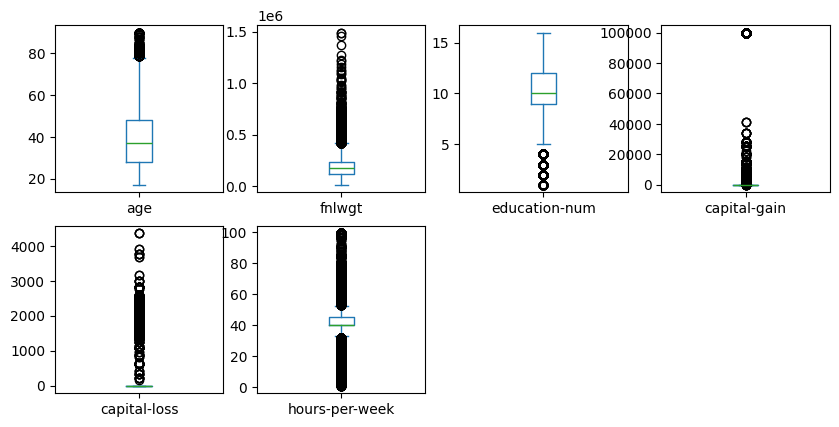

In [55]:
# Visualizamos los outliers
import matplotlib.pyplot as plt
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(10,10))
plt.show()

In [56]:
# Funcion para hallar los outliers
def cap_outliers_iqr(data, var):
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    data[var] = data[var].apply(lambda x: lim_sup if x > lim_sup else (lim_inf if x < lim_inf else x))
    return data

In [57]:
columnas_numericas = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in columnas_numericas:
    data = cap_outliers_iqr(data, col)
    print(f"Outliers tratados en: {col}")

Outliers tratados en: age
Outliers tratados en: fnlwgt
Outliers tratados en: education-num
Outliers tratados en: capital-gain
Outliers tratados en: capital-loss
Outliers tratados en: hours-per-week


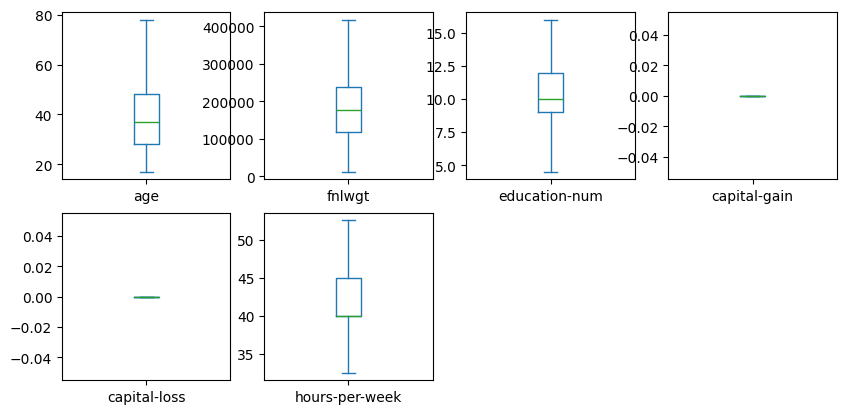

In [58]:
# Visualizamos los outliers
import matplotlib.pyplot as plt
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(10,10))
plt.show()

### b. Calcule el information value (IV) y seleccione las mejores variables, además, aplique un escalamiento a las variables numéricas y convierta las variables categóricas a dummies. Separe los datos en entrenamiento (80%) y prueba (20%) y realice un balanceo de clases.

In [59]:
# 4. Limpiar income y convertir a binaria (0 para <=50K, 1 para >50K)
data['income'] = data['income'].str.strip().str.replace('.', '', regex=False)
data['income'] = data['income'].replace({'<=50K': 0, '>50K': 1})

# 5. Identificar columnas numéricas y categóricas
columnas_numericas = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
columnas_categoricas = [col for col in data.columns if data[col].dtype == 'object' and col != 'income']

# 6. Escalar variables numéricas
scaler = StandardScaler()
data[columnas_numericas] = scaler.fit_transform(data[columnas_numericas])

# 7. Convertir variables categóricas a dummies
data = pd.get_dummies(data, columns=columnas_categoricas, drop_first=True)

# 8. Separar X e y
X = data.drop('income', axis=1)
y = data['income']

# 9. Separar en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Balanceo de clases (sobremuestreo)
train_data = pd.concat([X_train, y_train], axis=1)
mayor = train_data[train_data['income'] == 0]
minor = train_data[train_data['income'] == 1]

print("Distribución original en y_train:")
print(y_train.value_counts())

# Aplicar balanceo si hay registros de la clase 1
if len(minor) > 0:
    minor_upsampled = resample(minor, replace=True, n_samples=len(mayor), random_state=42)
    train_balanceado = pd.concat([mayor, minor_upsampled])

    # Actualizar X_train e y_train
    X_train = train_balanceado.drop('income', axis=1)
    y_train = train_balanceado['income']

    print("\nBalanceo realizado correctamente.")
    print("Distribución balanceada en y_train:")
    print(y_train.value_counts())
else:
    print("⚠️ No se encontraron registros de la clase 1 para balancear.")

Distribución original en y_train:
income
0    29741
1     9332
Name: count, dtype: int64

Balanceo realizado correctamente.
Distribución balanceada en y_train:
income
0    29741
1    29741
Name: count, dtype: int64


### c. Entrene los modelos k-NN, SVM, regresión logística, árbol de clasificación y Random Forest utilizando hiperparámetros estándar, búsqueda en cuadrícula y búsqueda aleatoria para poder encontrar el modelo de clasificación con mejor desempeño. Luego, obtenga el mejor accuracy junto con los hiperparámetros óptimos para dicho modelo.

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 1. Modelos rápidos con pocos hiperparámetros
modelos = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5],
            'weights': ['uniform']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [0.1, 1],
            'solver': ['liblinear']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [5, None],
            'criterion': ['gini']
        }
    }
}

# 2. Entrenar con RandomizedSearchCV rápido
mejores_modelos = []
for nombre, dic in modelos.items():
    print(f"\n🔍 Entrenando modelo: {nombre}")
    search = RandomizedSearchCV(
        dic['model'],
        dic['params'],
        n_iter=2,
        cv=2,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"📌 Mejores parámetros: {search.best_params_}")

    mejores_modelos.append({
        'nombre': nombre,
        'accuracy': acc,
        'mejores_parametros': search.best_params_,
        'modelo': search.best_estimator_
    })

# 3. Mostrar el mejor modelo
mejor = max(mejores_modelos, key=lambda x: x['accuracy'])

print("\n🏆 Mejor modelo final:")
print(f"Modelo: {mejor['nombre']}")
print(f"Accuracy: {mejor['accuracy']:.4f}")
print(f"Hiperparámetros óptimos: {mejor['mejores_parametros']}")


🔍 Entrenando modelo: KNN
✅ Accuracy: 0.7647
📌 Mejores parámetros: {'weights': 'uniform', 'n_neighbors': 3}

🔍 Entrenando modelo: LogisticRegression
✅ Accuracy: 0.7861
📌 Mejores parámetros: {'solver': 'liblinear', 'C': 0.1}

🔍 Entrenando modelo: DecisionTree
✅ Accuracy: 0.7794
📌 Mejores parámetros: {'max_depth': None, 'criterion': 'gini'}

🏆 Mejor modelo final:
Modelo: LogisticRegression
Accuracy: 0.7861
Hiperparámetros óptimos: {'solver': 'liblinear', 'C': 0.1}
